# Web of Lies - PDO Prompt Optimization

This notebook demonstrates using **PDO (Prompt Duel Optimizer)** to optimize prompts for the close-ended, binary Yes-or-No logical reasoning task **Web of Lies**

### What is Web of Lies?

Web of Lies is part of [**BIG-Bench Hard (BBH)**](https://github.com/suzgunmirac/BIG-Bench-Hard), a suite of 23 challenging tasks from BIG-Bench where language models previously failed to outperform average human-rater performance.

The task tests logical reasoning by presenting chains of statements about people who either always tell the truth or always lie. The model must determine whether the final person in the chain tells the truth.

**Example:**
```
Question: Sherrie tells the truth. Vernell says Sherrie tells the truth. 
Alexis says Vernell lies. Michaela says Alexis tells the truth. 
Elanor says Michaela tells the truth. Does Elanor tell the truth?

Answer: No
```

**Citation:** Suzgun et al., 2022 - [Challenging BIG-Bench Tasks and Whether Chain-of-Thought Can Solve Them](https://arxiv.org/abs/2210.09261)

## Quick Start

1. **Set up your API key** - Create a `.env` file in the project root:
   ```
   OPENROUTER_API_KEY=your_api_key_here
   ```

2. **Run this notebook** to:
   - Install prompt-ops in editable mode
   - Load your OpenRouter credentials
   - Run PDO optimization on the web_of_lies dataset
   - Evaluate optimized vs baseline prompts

## What is PDO?

PDO uses dueling bandits and Thompson sampling to evolve prompts through competitive evaluation, automatically discovering which reasoning strategies work best.


In [25]:
# Load OpenRouter API key from fixed path
import os
from dotenv import load_dotenv

# Load exactly this file
load_dotenv("/Users/yuanchenwu/Downloads/prompt-ops/local.env")

# Verify the API key is loaded
api_key = os.environ.get("OPENROUTER_API_KEY")
if api_key:
    print("OPENROUTER_API_KEY loaded successfully (length):", len(api_key))
else:
    print("WARNING: OPENROUTER_API_KEY not found at /Users/yuanchenwu/Downloads/prompt-ops/local.env")
    print("Ensure it contains: OPENROUTER_API_KEY=your_api_key_here")

OPENROUTER_API_KEY loaded successfully (length): 73


## 1. Define the input config

For close-ended tasks, we need to specify the set of possible final answers that the LLM is instructed to produce through guided decoding. For Web of Lies, since this is a binary-answer task, we have the following configuration:

```yaml
optimization:
  task_type: close_ended
  answer_choices: ["Yes", "No"]   # Choices used only for close-ended tasks
```

## 2. Run label-free prompt optimization

Now, we are ready to run PDO on the close-ended Web of Lies task using the configurations described above.

In [ ]:
# Run PDO optimization on the Web of Lies task
!prompt-ops migrate --config config.yaml --log-level INFO

After running PDO, we store the optimized prompt as follows, ready for final evaluation.

In [1]:
optimized_prompt='''Analyze the given statements about individuals telling the truth or lying, state assumptions about the truthfulness of each person based on the chain of statements, and determine the truthfulness of the last person mentioned in the question. For example, if Person A says Person B is lying and Person B says Person C is telling the truth, and it's given that Person A is lying, then Person B must be telling the truth, which means Person C is also telling the truth. Another example: if Person X claims Person Y is lying and Person Y says Person Z is truthful, but it's known that Person X is truthful, then Person Y is lying, and thus Person Z's truthfulness depends on the statement Person Y made about them. Apply this reasoning process to the given statements, as in the case where Person P says Person Q is lying, Person Q says Person R is telling the truth, and Person R says Person S is lying - determine the truthfulness of Person S based on the assumptions made about each person's statement.'''

## 3. Evaluate the optimized prompt

In this section, we evaluate the optimized prompt against heuristic prompting strategies such as Chain-of-Thought (CoT) and Plan-and-Solve (PaS). We report accuracy as the evaluation metric.

In [2]:
# Evaluate PDO (optimized) and baselines (zero_shot, CoT, PoS) on web_of_lies.json
import os, sys, json
sys.path.append(os.path.abspath("../../src"))

from prompt_ops.core.pdo.meta_prompt import REASON_PROMPT, get_reason_schema
from prompt_ops.core.model import setup_model

# Load dataset from the current use case directory
data_path = "data/web_of_lies.json"
rows = json.load(open(data_path, "r"))
gold = [r["answer"].strip() for r in rows]
answer_choices = ["Yes", "No"]
answer_choices_str = ", ".join(answer_choices)

# Model (match your optimization setup)
model = setup_model(
    adapter_type="litellm",
    model_name="openrouter/meta-llama/llama-3.3-70b-instruct",
    api_base=os.environ.get("OPENROUTER_API_BASE", "https://openrouter.ai/api/v1"),
    api_key=os.environ.get("OPENROUTER_API_KEY"),
    max_tokens=4096,
    temperature=0.0,
)

def _parse_json(s: str):
    try:
        start = s.find("{"); end = s.rfind("}") + 1
        blob = s[start:end] if (start >= 0 and end > start) else s
        return json.loads(blob)
    except Exception:
        return {}

def evaluate_instruction(instruction_text: str) -> float:
    prompts = [
        REASON_PROMPT.format(
            instruction=instruction_text,
            question=r["input"],
            answer_choices_str=answer_choices_str,
        )
        for r in rows
    ]
    response_format = {
        "type": "json_schema",
        "json_schema": {
            "name": "reasoned_answer",
            "schema": get_reason_schema(answer_choices),
            "strict": True,
        },
    }
    try:
        preds_raw = model.generate_batch(
            prompts, max_threads=4, temperature=0.0, response_format=response_format
        )
    except Exception:
        preds_raw = model.generate_batch(prompts, max_threads=4, temperature=0.0)

    pred = []
    for s in preds_raw:
        obj = _parse_json(s)
        a = str(obj.get("answer", "")).strip()
        if not a:
            a = answer_choices[0]  # fallback to first base choice
        a = "Yes" if a.lower().startswith("y") else "No" if a.lower().startswith("n") else a
        pred.append(a)

    correct = sum(1 for p, g in zip(pred, gold) if p == g)
    return correct / len(gold)

STATIC_PROMPTS = {
    "No Prompt": "Answer the following question.",
    "CoT": "Lets think step by step.",
    "PoS": "First, devise a plan by breaking the problem into ordered subtasks. Then, based on that plan, solve each subtask and give the final answer.",
}

results = {}

# PDO (optimized)

print("\nEvaluating PDO (optimized) prompt:\n", optimized_prompt)
results['PDO'] = evaluate_instruction(optimized_prompt)

# Baselines
for name, instr in STATIC_PROMPTS.items():
    print(f"\nEvaluating baseline '{name}' prompt:\n", instr)
    results[name] = evaluate_instruction(instr)

print("\n=== Accuracy on web_of_lies ===")
if 'PDO' in results:
    print(f"PDO (optimized): {results['PDO']:.3f}")
for name in ["No Prompt","CoT", "PoS"]:
    if name in results:
        print(f"{name}: {results[name]:.3f}")

/Users/yuanchenwu/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-11 02:57:56,208 | INFO    |  Using model with LiteLLM: openrouter/meta-llama/llama-3.3-70b-instruct



Evaluating PDO (optimized) prompt:
 Analyze the given statements about individuals telling the truth or lying, state assumptions about the truthfulness of each person based on the chain of statements, and determine the truthfulness of the last person mentioned in the question. For example, if Person A says Person B is lying and Person B says Person C is telling the truth, and it's given that Person A is lying, then Person B must be telling the truth, which means Person C is also telling the truth. Another example: if Person X claims Person Y is lying and Person Y says Person Z is truthful, but it's known that Person X is truthful, then Person Y is lying, and thus Person Z's truthfulness depends on the statement Person Y made about them. Apply this reasoning process to the given statements, as in the case where Person P says Person Q is lying, Person Q says Person R is telling the truth, and Person R says Person S is lying - determine the truthfulness of Person S based on the assumptio

The optimized prompt learned by PDO significantly outperforms all baselines, achieving a **0.928** accuracy, which is notably higher than both heuristic strategies (CoT and PaS) and the no-prompt baseline.

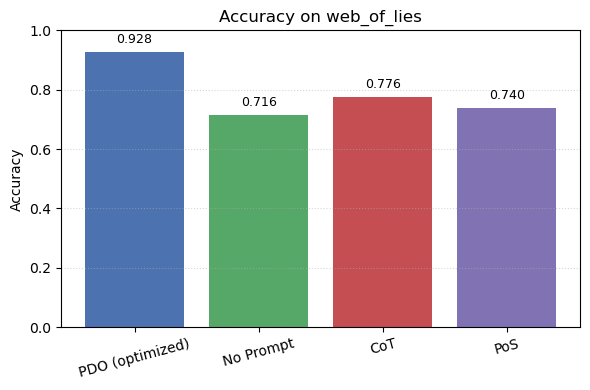

In [3]:
# Plot accuracy results
import numpy as np
import matplotlib.pyplot as plt

labels = ["PDO (optimized)", "No Prompt", "CoT", "PoS"]
keys = ["PDO", "No Prompt", "CoT", "PoS"]
values = [results.get(k, np.nan) for k in keys]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=["#4c72b0", "#55a868", "#c44e52", "#8172b3"])
ax.set_ylim(0.0, 1.0)
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy on web_of_lies")
ax.grid(axis="y", linestyle=":", alpha=0.5)
plt.xticks(rotation=15)

# Annotate bars
for b, v in zip(bars, values):
    if np.isfinite(v):
        ax.annotate(f"{v:.3f}", xy=(b.get_x() + b.get_width() / 2, v),
                    xytext=(0, 4), textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
